### ARR Forecasting Model for B2B Saas companies

We wish to construct a Bayesian model so that a B2B company can forecast its ARR ahead in time.

ARR generation happens following this steps:

- Marketing Team generates a Deal pipeline, that is materialized by opportunities (possible deals)
- The Sales Team calls the corresponding prospects to push the opportunities ahead in the conversion funnel. While doing so they attribute to each opportunity:
  - An Amount
  - A commitment (No Commitment ~ early stage / Best Case ~ Negociating/ Worse Case ~ Finalizing contract)
  - A close date (estimated date of closing)
- In this process Sales reps end up closing opportunities marking them as Won or Lost. When an opportunity is closed: the close date becomes final and the commitment is overriden to Won or Lost.

On the basis of historical data, we want to forecast the ARR of a quarter given the list of opportunities at time t.

The Forecast at time t is $F_t$ = $N_t$ x $A_t$ x $C_t$

Where:

- $N_t$ is the number of opportunities at time t
- $A_t$ is the amount at time t
- $C_t$ is the commitment at time t

t is the number of days before quarter end, it is a positive integer. We want to forecast a quarter 250 days ahead. So we have 0 <= t <= 250.

Taking time into account is very important. Far ahead in time, the list of opportunities will be small and as Sales would not have started discussions with the propects commitment will be weak. This situation evolves progressively in the quarter.

In this document, we will focus on setting up a generative model for $N_t$, $A_t$ and $C_t$

We will take the following hypothesis:

- The average deal size of our company is 15K €
- The average Sales cycle is ~ 3-6 months

Later improvement could also factor in:

- Seasonality (which quarter)
- Team member operating the deal
- Team to which the Sales belongs
- Forecasting $N_t$ based on the Lead generation (see below)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

## Number of Opportunities at time t : $N_t$ 

We know that the growth in the number of opportunities is not linear.

It will be high and decay until reaching 0 in the last month of the quarter (opportunities continue to be generated but for next quarters).

In [3]:
N_outcome = 10
nb_oppties_quarter_end = 100
time_steps = - np.array(range(251))
t_min = min(time_steps)

Let's simulate:

- An average ~ 20% growth rate of the number of opportunities during the 250 days preceding the end of the quarter
- A decaying growth rate ~ 18%

In [4]:
decay = 0.18
growth = 0.2

alpha = np.exp(stats.norm.rvs(np.log(decay),0.3,size=N_outcome))
gamma_ratio = np.exp(stats.norm.rvs(np.log(growth),0.1,size=N_outcome))
gamma = -t_min*gamma_ratio

In [5]:
nb_oppty_exp = np.zeros((len(time_steps),N_outcome))

for i,t in enumerate(time_steps):
    
    sim_exp = nb_oppties_quarter_end - alpha*np.exp(-t/gamma)
    
    nb_oppty_exp[i:None]=sim_exp

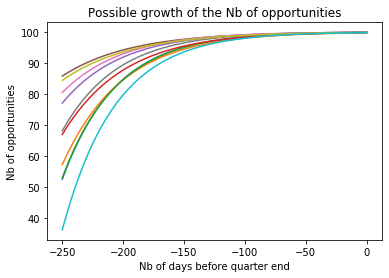

In [6]:
plt.plot(time_steps,nb_oppty_exp)
plt.xlabel("Nb of days before quarter end")
plt.ylabel("Nb of opportunities")
plt.title("Possible growth of the Nb of opportunities");

The simulation above seems well in the outcome space.

We could even go further and model the growth in the number of opportunities according the number of Leads generated.

## Amount of Opportunities at time t $A_t$ 

Let's generate the Amount of the Opportunities at time t= -250

In [7]:
avg_deal_amount = 15000

In [8]:
amounts_0 = np.exp(stats.norm.rvs(np.log(avg_deal_amount),0.9,size=nb_oppties_quarter_end))

In [9]:
y = stats.norm.pdf(np.linspace(0,np.log(150000),nb_oppties_quarter_end),np.log(avg_deal_amount),0.9)

In [10]:
x = np.exp(np.linspace(0,np.log(150000),nb_oppties_quarter_end))

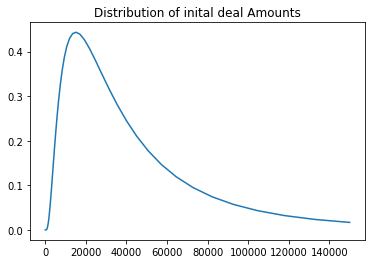

In [11]:
plt.plot(x,y)
plt.title("Distribution of inital deal Amounts");

The core market of the company focuses on deals ~ 15k€ but there are also some bigger deals at play ~ 100 k€. That's what we want.

The initial amount of the deal is not enough though. During the negociation with the prospect, this amount is bound to change. We need to simulate this.

In [12]:
amounts_by_step = np.ones((abs(t_min)+1,nb_oppties_quarter_end))
amounts_by_step[0:]=amounts_0
amount_change = amounts_0
for i in range(1,abs(t_min)):
    amount_change = amount_change * (1 - stats.bernoulli.rvs(0.008,size=nb_oppties_quarter_end)*stats.norm.rvs(0,0.25,size=nb_oppties_quarter_end)) 
    amounts_by_step[i:] = amount_change

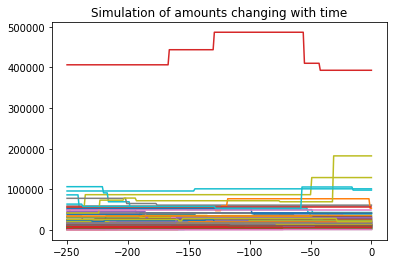

In [13]:
x = -np.array(range(abs(t_min)+1))
for i in range(nb_oppties_quarter_end):
    plt.plot(x,amounts_by_step[:,i])
    
plt.title("Simulation of amounts changing with time");

## Commitment on Opportunities at time t :  $C_t$

### Description

$C_t$ is an ordered variable. It takes the following value:

- *Lost*: No deal will be generated from this opportunity. Probability of success is 0%
- *No commitment*: The opportunity is in its early stage. Probability of success is ~ 5% (with uncertainty)
- *Best case*: The opportunity is on its way. Probability of success is ~ 30% (with uncertainty)
- *Worse case*: The negociation is advanced. Probability of success is ~ 70% (with uncertainty)
- *Won*: The deal has been signed. Probability of success is 100%.

To estimate the probability of success of an opportunity, we need to do 2 things:

- Assign a probability to each commitment value
- Make these commitment probability values vary across time. For instance, a *No commitment* opportunity 250 days before quarter end has a fair chance to become a *Won* deal while a *No commitment* opportunity 30 days before closing won't be the Sales rep's priority anymore.

Across time, we also have variations in the distribution of the proportion of commitments. For instance, there will be a vast majority of *No commitment* opportunities at 250 days before quarter end, few of them 30 days before quarter end.

### Resolution ideas


k is an integer in 0..4 that represents the values of the commitment listed above.
We want to express P[$C_t$ = k] as a function of:

- The previous lag (or lags)
- The value of t
- The Amount of the opportunity (Opportunities with high amounts are harder to turn into deals)

*This seems to me like an Ordered categorical outcome for which we could use an Ordered-logit likelihood.* As described in Statistical Rethinking page 384 onwards. Some material concerning the Ordered-logit for time series is also [https://projecteuclid.org/download/pdf_1/euclid.ss/1076102425](avaible here) page 361 & 362.

Once we get the probabilities of P[$C_t$ = k] for k in 0..4, we shall estimate the probabibility of turning an opportunity given P[$C_t$ = k] for k in 0..4

In order to model the kind of time dependancy we are dealing with, I have plotted below what a typical distribution of number of opportunities across time would look like.

In [14]:
N = 1
nb_oppties_quarter_end = 100
time_steps = - np.array(range(251))
t_min = min(time_steps)

In [15]:
no_commit = -0.4 * time_steps

In [16]:
def best_case(t):
    if t <= -100:
        c = 0.25 * (t - t_min)
    else:
        c = -.38 * t
    return c

In [17]:
def worse_case(t):
    if t <= -60:
        d = 0.1 * (t - t_min)
    else:
        d = -.32 * t
    return d

In [18]:
def won(t):
    if t >=-60:
        e = 0.35*(t + 60)
    else:
        e = 0
    return e

In [19]:
def lost(t):
    return 100 - best_case(t) -worse_case(t) - won(t) - no_commit[int(-t)]

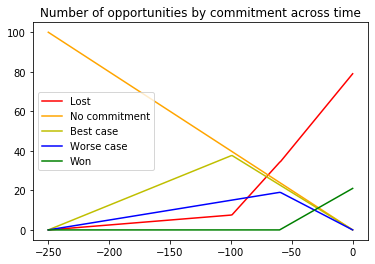

In [25]:
plt.plot(time_steps,np.array(list(map(lost, time_steps))),label="Lost",color="r")
plt.plot(time_steps,no_commit,label="No commitment",color="orange")
plt.plot(time_steps,np.array(list(map(best_case, time_steps))),label="Best case",color="y")
plt.plot(time_steps,np.array(list(map(worse_case, time_steps))),label="Worse case",color="b")
plt.plot(time_steps,np.array(list(map(won, time_steps))),label="Won",color="g")
plt.legend()
plt.title("Number of opportunities by commitment across time");


## In progress (do not read)

In [16]:
q = [0,0.05,0.3,0.7,1.]

In [17]:
p = np.zeros(5)
p[0] = q[0]
p[1] =  q[1] - q[0]
p[2] =  q[2] - q[1]
p[3] =  q[3] - q[2]
p[4] = q[4] - q[3]

In [19]:
p

array([0.  , 0.05, 0.25, 0.4 , 0.3 ])

In [20]:
dirichou = stats.dirichlet.rvs((1,5,10,6),size=10)

In [21]:
dirichou

array([[0.00215338, 0.17384741, 0.46249496, 0.36150424],
       [0.01623933, 0.2508292 , 0.43730872, 0.29562275],
       [0.02256204, 0.19024529, 0.6454252 , 0.14176748],
       [0.00890763, 0.27976426, 0.38457598, 0.32675213],
       [0.10795203, 0.15710293, 0.50606336, 0.22888169],
       [0.00277755, 0.33183278, 0.35138374, 0.31400593],
       [0.08080465, 0.25205172, 0.30869048, 0.35845316],
       [0.01272086, 0.23205977, 0.60924443, 0.14597494],
       [0.05592516, 0.20502469, 0.4767276 , 0.26232254],
       [0.00779986, 0.13573282, 0.66853313, 0.18793419]])

In [22]:
def proba_from_dirichou(x,commit=3):
    return dirichou[:,:commit].sum(axis=1)

In [23]:
proba_from_dirichou(dirichou,2)

array([0.17600079, 0.26706853, 0.21280732, 0.28867188, 0.26505496,
       0.33461033, 0.33285636, 0.24478063, 0.26094985, 0.14353268])

To include commitments in our model, we choose:

- To consider the commitment as time t+1 as a function of the commitment at time t
- Then to feed a linear model with this prediction. There are patterns that depends on t (and on how close a particular point is from quarter end)

In [169]:
def generate_oppty_data(nb,t):
    all_names = []
    all_time = []
    all_amount = []
    name = []
    time = []
    amount = []
    for i in range(nb):
        name.append("Oppty - " + str(i))
        time.append(-t)
        amount.append(amounts_by_step[t,i])
    all_names = np.concatenate([all_names,name])
   
    all_time = np.concatenate([all_time,time])
    all_amount = np.concatenate([all_amount,amount])
    return all_names,all_time,all_amount

In [198]:
all_names = []
all_time = []
all_amount = []
for i,nb in enumerate(nb_oppties):
    all_names.append(generate_oppty_data(nb,i)[0])
    all_time.append(generate_oppty_data(nb,i)[1])
    all_amount.append(generate_oppty_data(nb,i)[2])
    

In [199]:
all_names,all_time,all_amount = np.hstack(all_names),np.hstack(all_time),np.hstack(all_amount)

In [208]:
pd.DataFrame({'name': all_names, 'day': all_time, 'amount':all_amount})

,name,day,amount
0,Oppty - 0,0.0,6371.072220
1,Oppty - 1,0.0,12362.810523
2,Oppty - 2,0.0,14723.501344
3,Oppty - 3,0.0,19358.972630
4,Oppty - 4,0.0,22255.289862
...,...,...,...
23005,Oppty - 51,-250.0,8431.294978
23006,Oppty - 52,-250.0,25192.060248
23007,Oppty - 53,-250.0,1499.793027
23008,Oppty - 54,-250.0,7927.165535
